# Calculating PMFs with AWH in GROMACS <a id='another_cell'></a>
Here we learn how to calculate the potential of mean force
(PMF) along a reaction coordinate (RC) using the accelerated weight
histogram method (AWH) in GROMACS.  We will go through both how to set
up the input files needed, as well as how to extract and analyze the
output after having run the simulation. For more information about
the AWH method itself and how it can be used we refer to \cite{}[TODO how cite?].
What you need to know right now is that AWH applies a time-dependent bias
potential along the chosen RC, which is tuned during the simulation
such that it "flattens" the barriers in the PMF to improve sampling along the RC.
With better sampling, the PMF can be calculated more accurately than using unbiased MD. [TODO Movie/figure?]

*Author: Viveca Lindahl   
Email: vivecal@kth.se*

## Prerequisites
This tutorial assumes you have/know
* basic knowledge of using a Linux shell 
* basic usage of the molecular visualization tool VMD
* an installation of GROMACS 2018.1 (available as gmx in your PATH)
* python modules numpy, matplotlib

## The case study: DNA base pair opening
We will calculate a PMF for opening a DNA base
pair. The DNA double helix is a very stable structure. Opening a base pair
requires breaking hydrogen bonds between the bases and crossing a high free energy
barrier.  That's why we need to enhance the sampling by applying a bias!
<img src="figs/dna-helix.png" alt="dna" style="height: 300px;"/>
As our RC we use the distance between the two atoms forming the central hydrogen-bond the two bases in a pair. Let's have a look at the system and the reaction coordinate using VMD. The `-e` flag below tells VMD to excute the commands that are in the following tcl-script. These commands change how the system is visually represented. For instance, we have hidden all the water to better see the DNA itself, and we have put punchy colors on the atoms defining the RC of our target base pair. Now run this and VMD should pop up:

In [ ]:
!vmd visualization/dna-centered.gro -e visualization/representation.tcl

Rotate the structure and look for the two (nitrogen) atoms in green. The distance between these will serve as our RC for that base pair.

## The MD parameter (.mdp) file 
We'll assume we have already built and equilibrated the system, so we are almost ready to go. To use AWH we basically just need to add some extra parameters in the mdp file. Go to and check out the directory that has all the run files of our first AWH example:

In [1]:
!pwd
%cd awh-1d
!ls -l

/home/viveca/awh-tutorial/dna-base-pair-opening
/home/viveca/awh-tutorial/dna-base-pair-opening/awh-1d
total 256
lrwxrwxrwx 1 viveca ipausers     31 May 25 14:40 amber99bsc1.ff -> ../template-npt/amber99bsc1.ff/
lrwxrwxrwx 1 viveca ipausers     24 May 25 14:40 conf.gro -> ../template-npt/conf.gro
drwxr-xr-x 2 viveca ipausers  69632 May 25 16:16 data
-rw-r--r-- 1 viveca ipausers   3005 May 25 14:42 grompp.mdp
-rw-r--r-- 1 viveca ipausers 181632 May 22 13:39 index.ndx
lrwxrwxrwx 1 viveca ipausers     25 May 25 14:40 topol.top -> ../template-npt/topol.top


In [ ]:
!pwd

Find the differences between this mdp file for AWH and an mdp file for a vanilla MD simulation:

In [ ]:
!diff ../template-npt/grompp.mdp grompp.mdp

Here '<' refers to the content of the first argument to `diff` (the NPT mdp) and '>' to the second (AWH mdp). E.g., we increased the number of steps (`nsteps`) for AWH. The more relevant parameters are the ones prefixed `pull` and `awh`. What do these parameters mean? Generally, google "gromacs documentation" to find out, but the comments in the mdp file should be enough here.

## The index (.ndx) file
The .mdp file now depends on some definitions of atom groups; we need to have an index file for these. Here our groups are as simple as they get: each group contains a single nitrogen atom. But don't get tempted to edit an index file manually! The traditional tool to use is `gmx make_ndx` and a more general and powerful tool is `gmx select`. We focus on AWH here and provide the index file, and leave the index file generation as an [exercise](#sec:make-index). Double-check that the groups we saw in the mdp file are actually defined in the index file:


In [ ]:
!grep -A 1  N1orN3  index.ndx  # '-A 1' to show also 1 line after the match 

One atom per group looks right. In a real study, a better check would be to visualize these atom indices (e.g. with VMD).

## Starting and analyzing the simulation
Now generate the tpr as usual with `grompp` (assuming default naming of input files grompp.mdp, conf.gro, topol.top, index.ndx) 

In [10]:
!gmx grompp -n -quiet

Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Setting the AWH bias MC random seed to 87827718
Setting the LD random seed to 410021846
Generated 2485 of the 2485 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2485 of the 2485 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'DNA_chain_A'
turning H bonds into constraints...
Excluding 3 bonded neighbours molecule type 'DNA_chain_B'
turning H bonds into constraints...
Excluding 2 bonded neighbours molecule type 'SOL'
turning H bonds into constraints...
Excluding 1 bonded neighbours molecule type 'NA'
turning H bonds into constraints...
Removing all charge groups because cutoff-scheme=Verlet
Pull group 1 'base_N1orN3' has 1 atoms
Pull group 2 'partner_N1orN3' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 19587.00
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.034 nm, buffer si

## Check the log file

Note that the values of the pull coordinate values in the provided .gro file are printed by grompp. Does it look reasonable? We now assume we have run a simulation using the. Some information related to the AWH initial convergence can be found in the `mdrun` log file.

In [16]:
!grep 'covering' data/md.log
!grep 'out of the' data/md.log

awh1: covering at t = 1243.8 ps. Decreased the update size.
awh1: covering at t = 1530 ps. Decreased the update size.
awh1: out of the initial stage at t = 1530.


In the intial stage, the free energy (and bias) update size is kept constant *during* each covering(=transition) across the sampling interval, and decreased in a stepwise manner after each covering.  After exiting the initial stage, the free energy update size will decrease steadily with time. The initial stage is a type of "burn-in" process that improves robustness of the method. The idea is to first get a quick and rough estimate in the intitial stage, followed by refinement in the final stage. 

## The reaction coordinate trajectory
The trajectory of the pull coordinate is found in `pullx.xvg`. For a quick look at the contents of such files from the terminal we can use the interactive plotting tool `xmgrace`

In [14]:
# -free for nice layout
# -nxy to plot multicolumn data
!xmgrace -free data/pullx.xvg # wait for it... 

For 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function that reads data of an .xvg file
def read_xvg(fname):
    data=[]
    with open(fname) as f: 
        for line in f:
            # Lines with metadata or comments start with #, @
            if not line.startswith(("@","#")):
                data.append(np.array([float(s) for s in line.split()]))
    data = np.vstack(data)
    return data

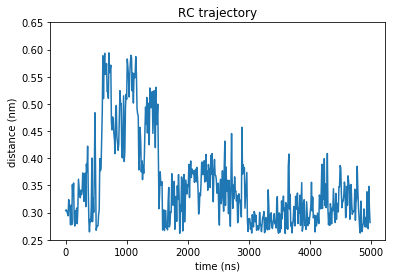

In [15]:
# Read pullx.xvg file and plot a selected part of the trajectory
data = read_xvg("data/pullx.xvg")
t, x = data[:,0], data[:,1]
tend =5000
selection = np.where(t<tend)
plt.plot(t[selection], x[selection])
ax = plt.gca()
# Tweak
plt.xlabel("time (ns)")
plt.ylabel("distance (nm)");
plt.ylim([0.25, 0.65])
plt.title('RC trajectory');

#texit = 1530
#plt.plot([texit,texit],[0,1])

Verify that the covering times correspond to the transition times in the trajectory (assuming the `pullx.xvg` output is frequent enough). Always check this trajectory and make sure that you are observing at least a few transitions after the initial stage. If not, you need to simulate longer or you might have an RC issue.

Data directly related to AWH is extracted using `gmx awh`. The data is stored in the energy file, `ener.edr`. The output is `awh_t<time>.xvg`; there will be one file for each AWH output time, or less if you use the `-skip` flag. The `-more` flag tells `gmx awh` to more than the PMF from the AWH files, e.g. histograms. The default gmx units of energy is kJ/mol, but with the flag `-kT` we get units of kT.

In [ ]:
!gmx awh -quiet -s topol.tpr -f data/ener.edr -more -kt

For a quick look at the contents of these files we can use the click-friendly plotting tool `xmgrace`, which recognizes xvg files

In [ ]:
t=50000 # ps
# -free for nice layout
# -nxy to plot multicolumn data
!xmgrace -free -nxy awh_t{t}.xvg # wait for it... 

The legends in the plot should help understanding what data is being plotted, but here's more:
* *PMF*: the free energy estimate along the RC
* *Coord bias*: the bias acting on the RC
* *Coord distr*: the observed distribution (histogram) of the RC, $\xi(x)$
* *Ref value distr*: weight histogram of reference coordinate value, $\lambda$
* *Target ref value distr*: the target distribution for $\lambda$ (uniform by default)
* Friction metric: a (here unitless) metric for local friction

Sanity checks for the distributions:
* *Coord distr* $\approx$ *Ref value distr*, or the force constant in the mdp file is too weak.
* *Ref value distr* $\approx$ *Target ref value distr*, or we may have a poor bias estimate/need to sample longer.

Let's look closer at the evolution of the PMF.

In [ ]:
import re # use regular expressions to find matching strings

# Plot PMFs from AWH xvg files

# A list of all AWH files
fnames = !ls awh_t*xvg

# Extract time of each file
times = [float(re.findall('awh_t(.+?).xvg', fname)[0]) for fname in fnames]

# Sort the files chronologically
fnames = [f for (t,f) in sorted(zip(times, fnames))]
times.sort()
print "Number of files:", len(fnames)
print "Time in between files ", times[1] - times[0], 'ps'
print "Last time", times[-1], 'ps'

In [ ]:
# Plot the PMF from first files/times
labels=[]
istart = 0  # Start plotting this file index
nplot = 10  # Number of files to plot
for fname in fnames[istart:istart+nplot]:
    data=read_xvg(fname)
    labels.append(re.findall('awh_t(.+?).xvg', fname)[0] + ' ps') # use the time as label
    plt.plot(data[:,0], data[:,1])
plt.xlabel('distance (nm)')
plt.ylabel('PMF (kT)')
plt.xlim([0.25,0.60])
plt.ylim([0,20])
plt.legend(labels);

Try increasing the `istart` variable above to see how the PMF estimates are changing less and less over time. *Note*: this convergence does not easily translate into error estimates for the PMF. To get such error bars the simplest is to run multiple (independent) AWH simulations and calculate standard errors from there [add exercise?]

In [ ]:
# Plot the histogram from first files/times
labels=[]
istart = 1000  # Start plotting this file index
nplot = 10  # Number of files to plot
for fname in fnames[istart:istart+nplot]:
    data=read_xvg(fname)
    labels.append(re.findall('awh_t(.+?).xvg', fname)[0] + ' ps') # use the time as label
    plt.plot(data[:,0], data[:,3])
plt.xlabel('distance (nm)')
plt.ylabel('bias()')
plt.xlim([0.25,0.60])
#plt.ylim([0,20])
plt.legend(labels)

That's about it for running an AWH simulation in GROMACS!

## Multiple bias sharing walkers
A simple way of parallelizing AWH is to run multiple simulations, using the `mdrun` flag `-multidir` and have them all share the collected samples and bias potential. This can reduce the length of the initial stage significantly. If we just apply `-multidir` we will get multiple *independent* simulations. We need to add a couple of things in the mdp file to make AWH share information across simulations

In [ ]:
!pwd
%cd ..

In [ ]:
!mkdir awh-multi 
!cp awh-1d/grompp.mdp awh-1d/topol.top awh-1d/index.ndx awh-1d/conf.gro awh-multi
!echo "awh-share-multisim = yes" >> awh-multi/grompp.mdp

## Extracurricular: effect of changing the force constant

## Extracurricular: effect of changing the diffusion parameter

## Extracurricular: making an index file  with `gmx select`
<a id='sec:make-index'></a>

but here I'll instead show how to use the flashier and more general tool `gmx select`. Learn about it using `gmx select -h`, as for any gmx command. Alternatively, the same information canbe found in the online GROMACS docs that you hopefully found above. HereFor making and index file we need to provide either a selection file (flag `-sf`) or a selection string (`-select`)

In [ ]:
!echo hello

In [ ]:
%pwd
%ls -l